In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import mridc
import h5py
from matplotlib import pyplot as plt

%matplotlib inline

In [14]:
def view_mri(data_dir, file_index=0, index=0, coil=0, figsize=(15, 4), show_real_imgag=False, save_location=None):
    file_names = os.listdir(data_dir)
    mri = h5py.File(os.path.join(data_dir, sorted(file_names)[file_index]))

    maps = []
    for key in mri.keys():
        field = mri[key]
        if len(field.shape)== 3:
            field = field[index, :, :]
        elif len(field.shape)== 4:
            field = field[index, coil, :, :]
            
        if np.iscomplex(field).any():
            map = np.abs(field)
            if key == "kspace":
                map = np.log(map + 1e-9)
            maps.append(map)
            if show_real_imgag:
                maps.append(np.real(field))
                maps.append(np.imag(field))
        else:
            maps.append(field)

    fig = plt.figure(figsize=figsize)
    for i, num in enumerate(maps):
        plt.subplot(1, len(maps), i + 1)
        ax = plt.imshow(num, cmap="gray")
        plt.colorbar(ax)
    plt.tight_layout()
    if save_location:
        plt.savefig(save_location, bbox_inches='tight', dpi=300, format='png')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/lgdejong/scratch/projects/mridc/mridc_experiments/example.png'

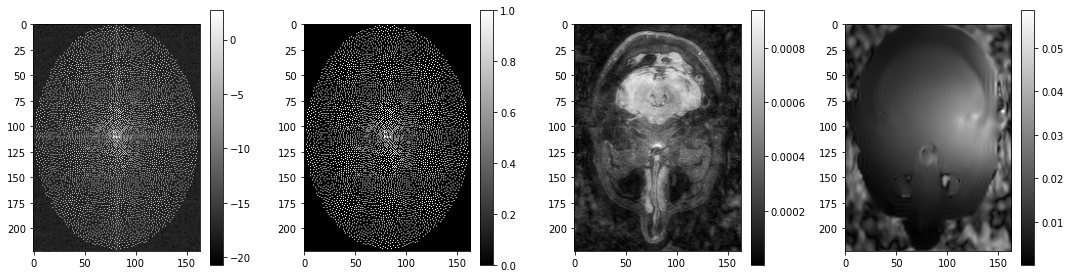

In [15]:
data_dir = "/data/projects/tecfidera/data/h5_new/nonorm/"

file_index = 0
index = 120
coil = 15

view_mri(data_dir, index=index, coil=coil, file_index=file_index, save_location="/home/lgdejong/scratch/projects/mridc/mridc_experiments/example.png")

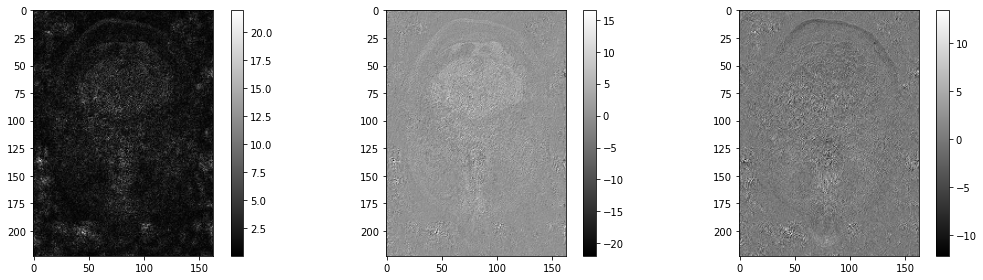

In [65]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_13-51-56/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

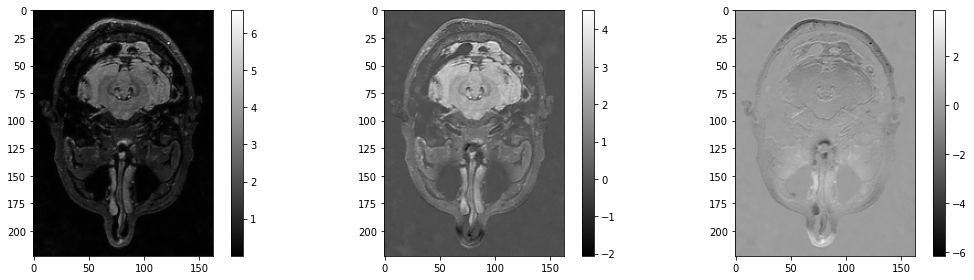

In [66]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_14-51-04/reconstructions/"


view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

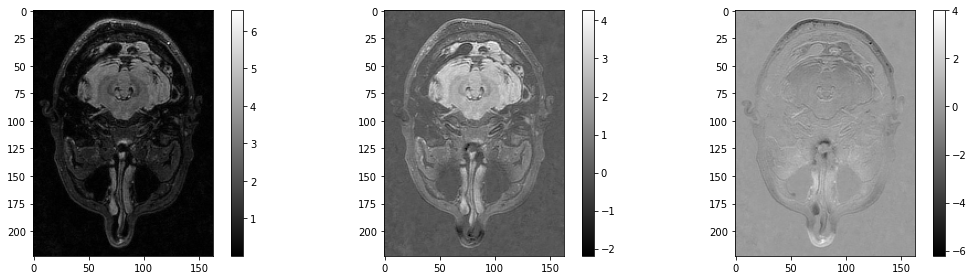

In [67]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_15-55-18/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

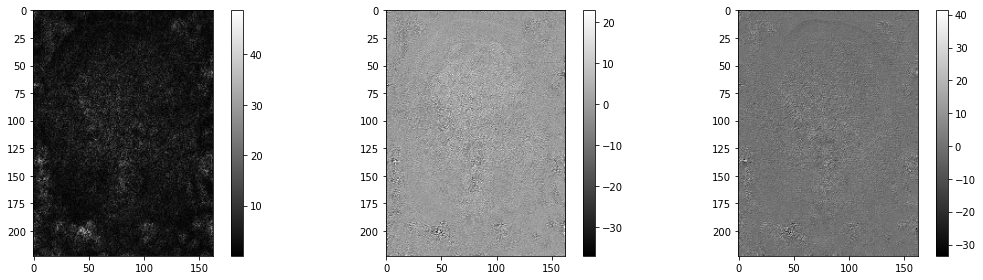

In [68]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_16-50-08/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

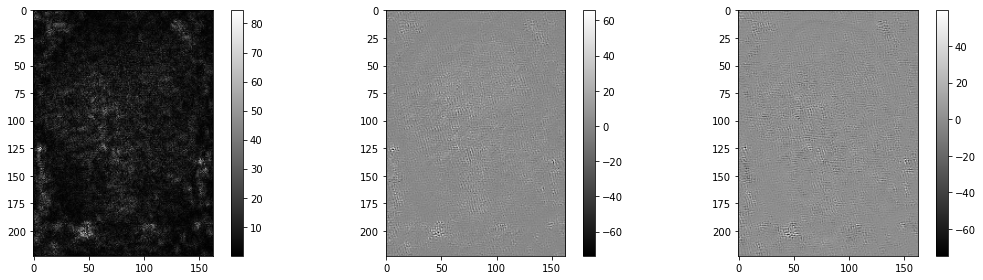

In [69]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_17-35-53/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

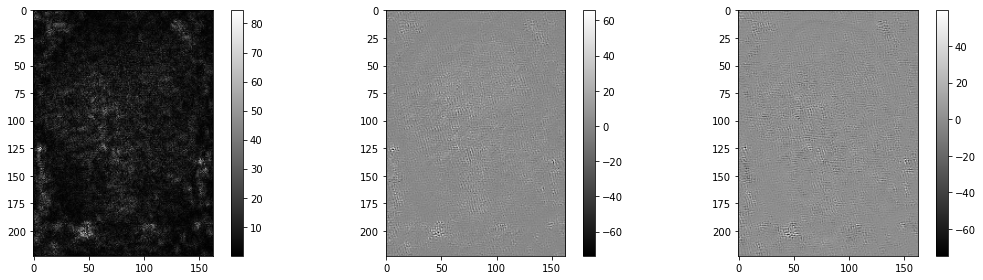

In [70]:
data_dir = "/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_17-35-53/reconstructions/"

view_mri(data_dir, index=index, coil=0, file_index=file_index, show_real_imgag=True)

In [71]:
from mridc.collections.common.parts.utils import complex_mul, to_tensor, tensor_to_complex_np
from mridc.collections.common.parts.fft import fft2c, ifft2c

def load_seg(data_path):
    seg_test = np.array(nib.load(data_path).dataobj)
    seg_test = np.transpose(seg_test, (2, 1, 0))
    seg_test = np.flip(seg_test, (0))
    seg_test = np.flip(seg_test, (2))
    return seg_test.astype(np.uint8)

def voting_segmentation():
    results = {}

    segmentation_data_path = "/data/projects/tecfidera/data/segmentations/NiftiSegmentations/"
    lesions_path = os.path.join(segmentation_data_path, "lesions")

    subjects_h5 = sorted(os.listdir("/data/projects/tecfidera/data/h5_new/nonorm/"))
    subjects_id = [i[:6] for i in subjects_h5]

    loop_list = sorted(os.listdir(lesions))
    master_list = []
    for i in subjects_id:
        tmp_file_list = []
        for j in loop_list:
            if i in j:
                tmp_file_list.append(j)
        master_list.append(tmp_file_list)

    for i, name in zip(master_list, subjects_h5):
        results[name] = np.add.reduce([load_seg(os.path.join(lesions, j, "FLAIR_lesion.nii.gz")) for j in i])
        results[name][results[name] < 2] = 0
        results[name][results[name] > 1] = 1
    return results

def sens_expand(x, sens_maps, fft_type="backward_norm"):
        x = to_tensor(x)
        sens_maps = to_tensor(sens_maps)    
        out = fft2c(complex_mul(x, sens_maps), fft_type=fft_type)
        return tensor_to_complex_np(out).astype(np.complex64)

def reconstruct_kspace(dataset_path, recon_data_path, annotation_path, output_path, fft_type="backward_norm", recon_model=None):
        dataset_files = sorted(os.listdir(dataset_path))
        recon_files = sorted(os.listdir(recon_data_path))
        segmentations_files = voting_segmentation()

        offset = [11, 5, 22, 14, 24, 8, 10, 11, 19, 11, 17, 14, 4, 8, 19, 20, 21, 10]

        for i, (dataset_file, recon_file, seg_file) in enumerate(zip(dataset_files, recon_files, segmentations_files)):
                data_path = os.path.join(dataset_path, dataset_file)
                recon_path = os.path.join(recon_data_path, recon_file)
                output = os.path.join(output_path, dataset_file[:-3] + "_transverse" + ".h5")

                if os.path.isfile(output):
                        continue

                sens_maps = h5py.File(data_path)["sensitivity_map"]
                reconstrution = h5py.File(recon_path)["reconstruction"]
                seg_test = segmentations_files[dataset_file]

                full_k_sapce = sens_expand(np.array(reconstrution)[offset[i]:offset[i]+200, :, :, :], np.array(sens_maps)[offset[i]:offset[i]+200, :, :, :], fft_type=fft_type)
                
                with h5py.File(output, "w") as hf:
                        hf.create_dataset("kspace", data=full_k_sapce.astype(np.complex64), compression='gzip')
                        hf.create_dataset("sensitivity_map", data=np.array(sens_maps).astype(np.complex64)[offset[i]:offset[i]+200, :, :], compression='gzip')
                        hf.create_dataset("reconstruction_sense", data=np.array(reconstrution).astype(np.complex64)[offset[i]:offset[i]+200, :, :], compression='gzip')
                        hf.create_dataset("lesion_segmentation", data=seg_test.astype(np.uint8)[offset[i]:offset[i]+200, :, :], compression='gzip')
                        if recon_model is not None:
                                hf.attrs['reconstruction_model'] = recon_model

(224, 32, 223, 163)


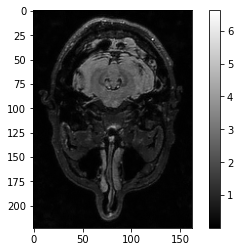

(224, 1, 223, 163)


In [72]:
partial_k_space = h5py.File("/data/projects/tecfidera/data/h5_new/nonorm/DMF007_T2_AXFLAIR.h5")
reconstrution = h5py.File("/scratch/lgdejong/projects/mridc/mridc_experiments/default/2022-03-03_14-51-04/reconstructions/DMF007_T2_AXFLAIR.h5")

sens_maps = partial_k_space["sensitivity_map"]
print(sens_maps.shape)
reconstrution = reconstrution["reconstruction"]
ax = plt.imshow((np.abs(reconstrution[index, 0, :, :])), cmap="gray")
plt.colorbar(ax)
plt.show()
print(reconstrution.shape)

In [73]:
full_k_sapce = sens_expand(np.array(reconstrution), np.array(sens_maps))

In [74]:
ticfedera_data = "/data/projects/tecfidera/data/h5_new/nonorm/"
recon_path = "/home/lgdejong/scratch/projects/mridc/mridc_experiments/default/2022-03-03_14-51-04/reconstructions/"
annotation_path = "/data/projects/tecfidera/data/segmentations/NiftiSegmentations/lesions/"
output = "/data/projects/tecfidera/data/h5_recon_dataset/"
reconstruct_kspace(ticfedera_data, recon_path, annotation_path, output, recon_model="fastmri_flair_320x320_CIRIM_8C_64F_l1_NODC")

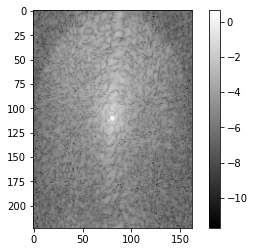

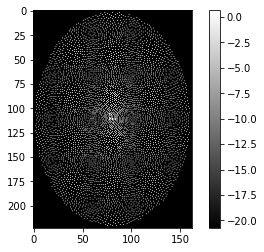

In [75]:
ax = plt.imshow(np.log(np.abs(full_k_sapce[index, 30, :, :])), cmap="gray")
plt.colorbar(ax)
plt.show()

ax = plt.imshow(np.log(np.abs(full_k_sapce[index, 30, :, :] * np.array(partial_k_space["mask"])) + 1e-9), cmap="gray")
plt.colorbar(ax)
plt.show()

In [76]:
segmentation_data_path = "/data/projects/tecfidera/data/segmentations/NiftiSegmentations/"
graymatter = os.path.join(segmentation_data_path, "graymatter")
lesions = os.path.join(segmentation_data_path, "lesions")
whitematter = os.path.join(segmentation_data_path, "whitematter")

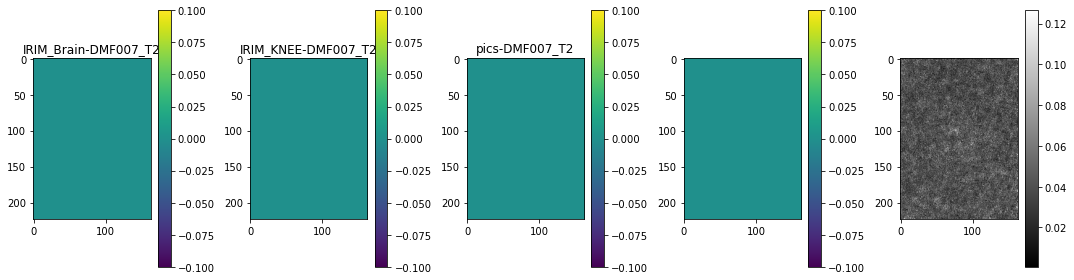

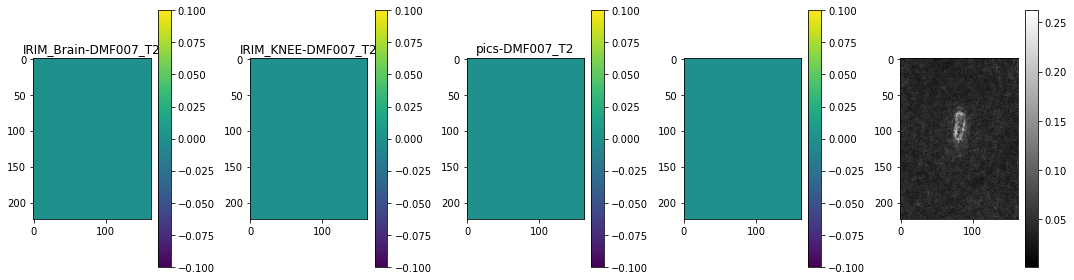

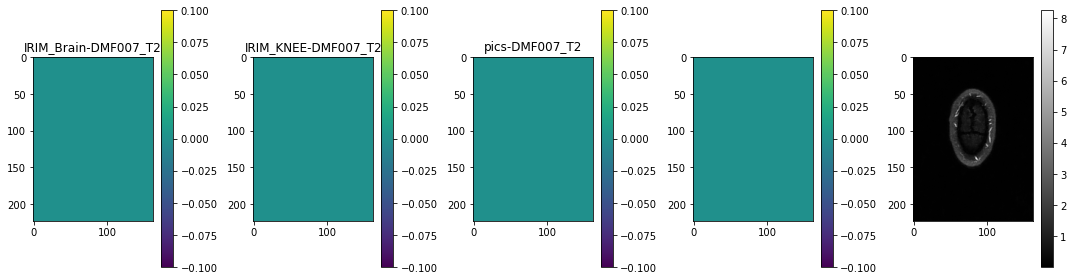

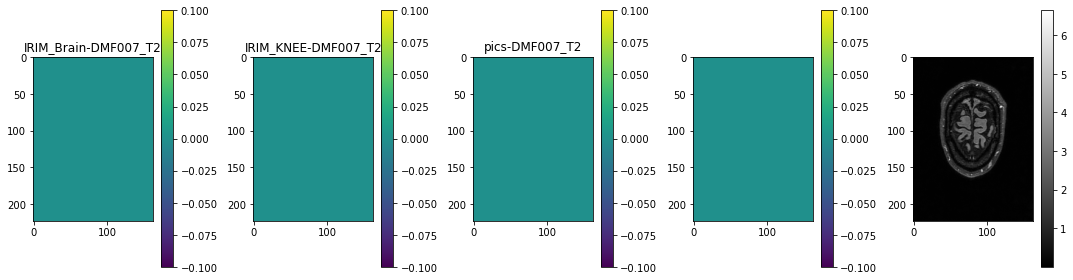

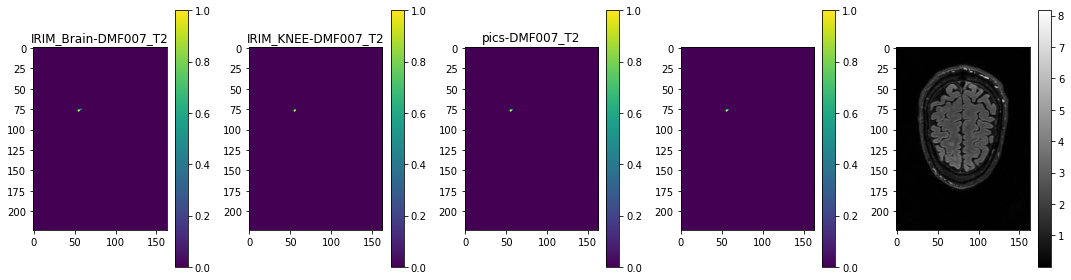

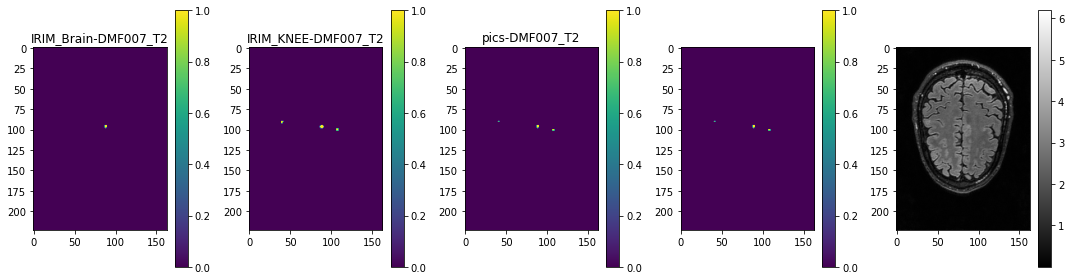

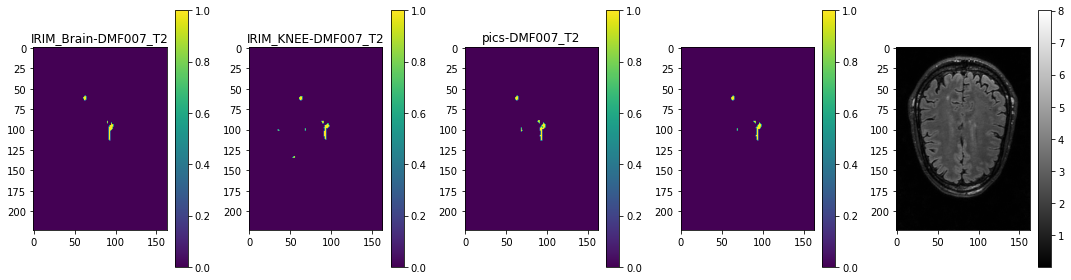

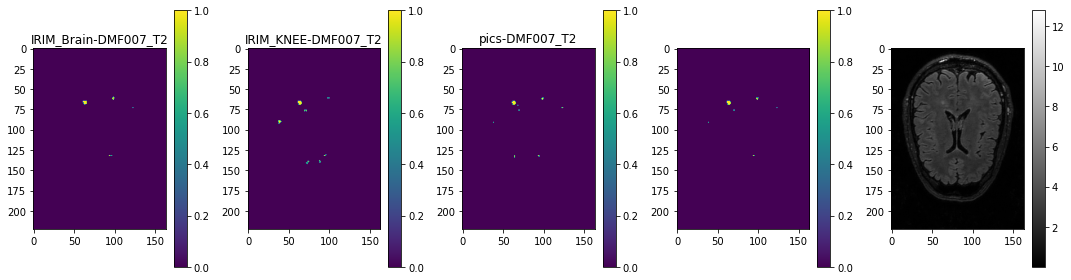

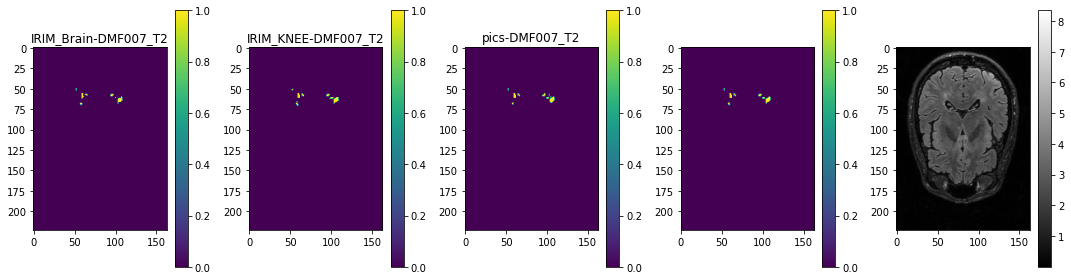

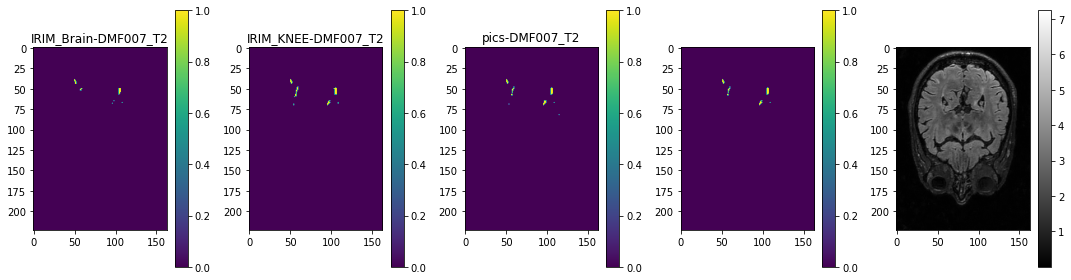

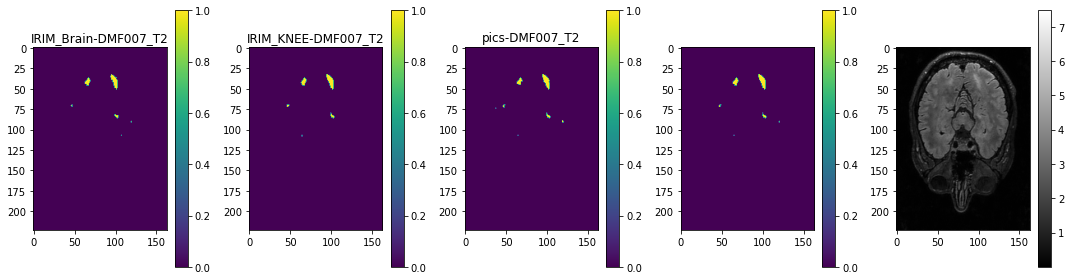

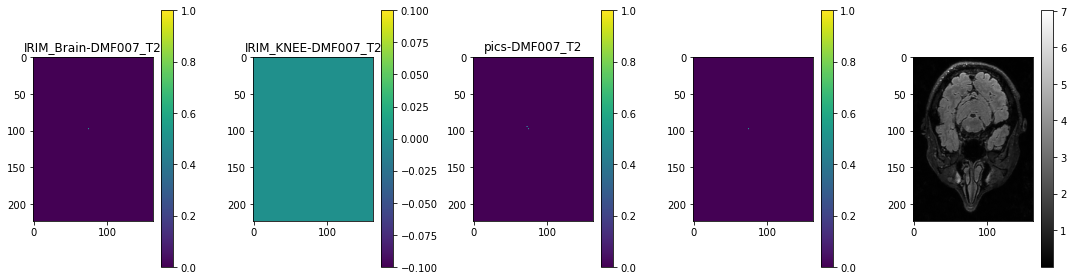

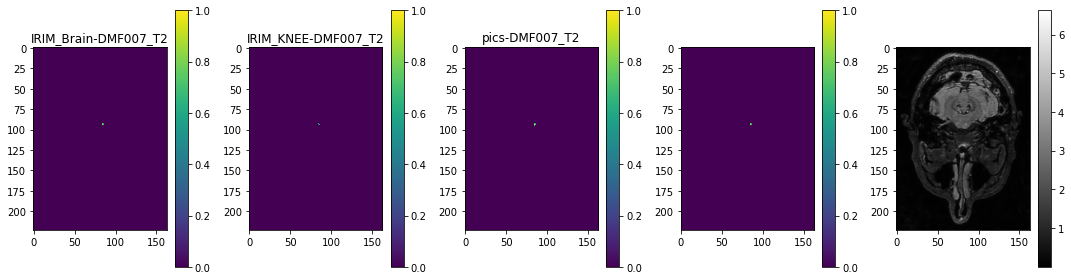

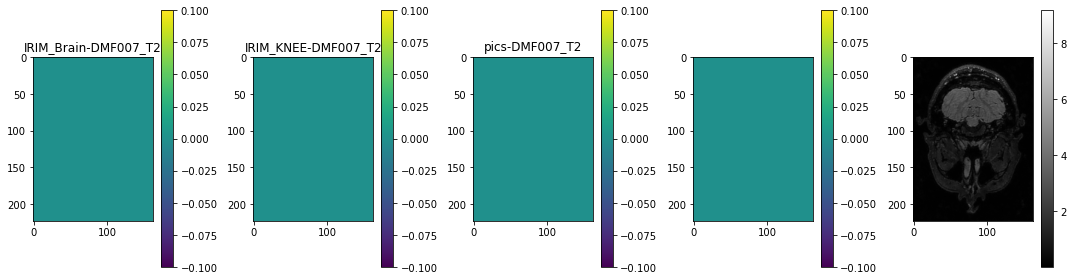

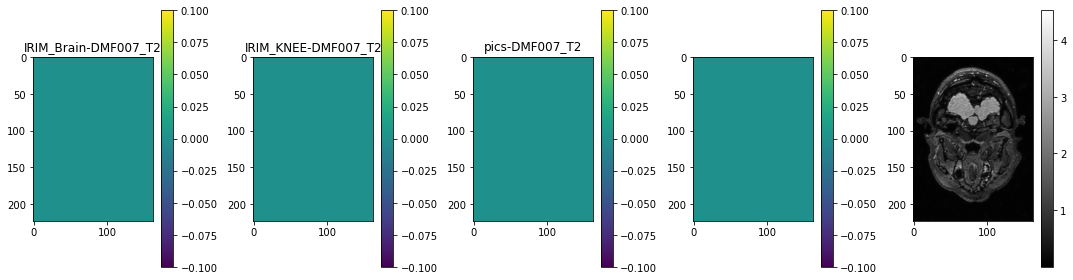

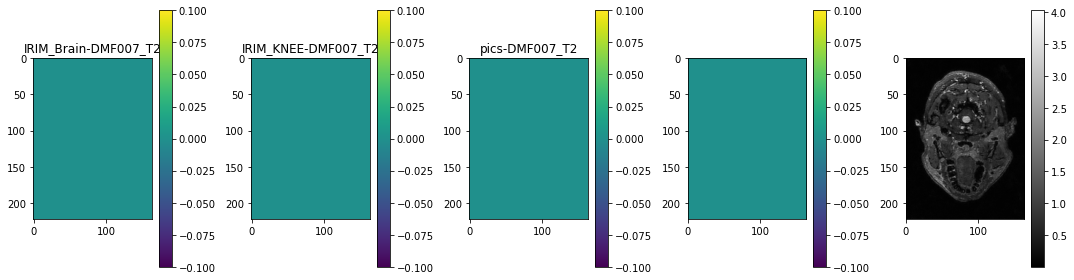

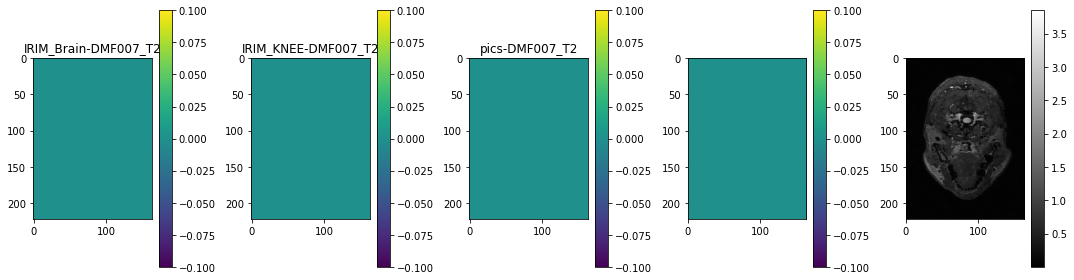

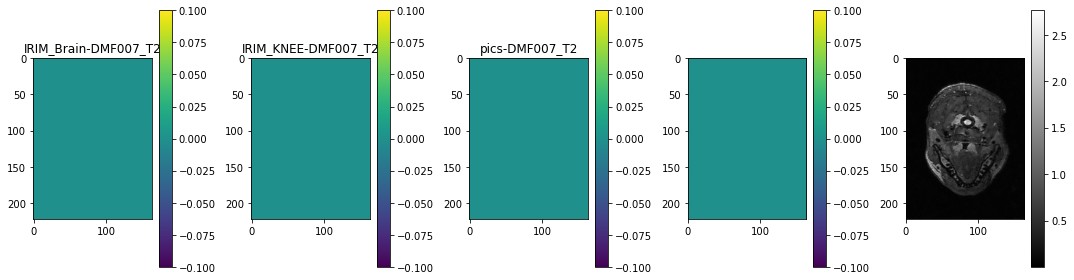

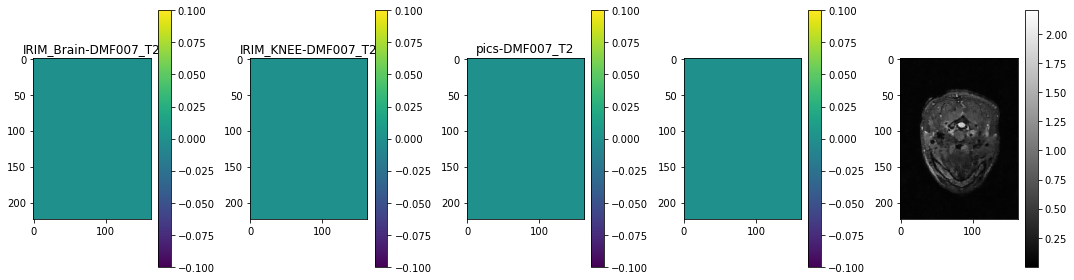

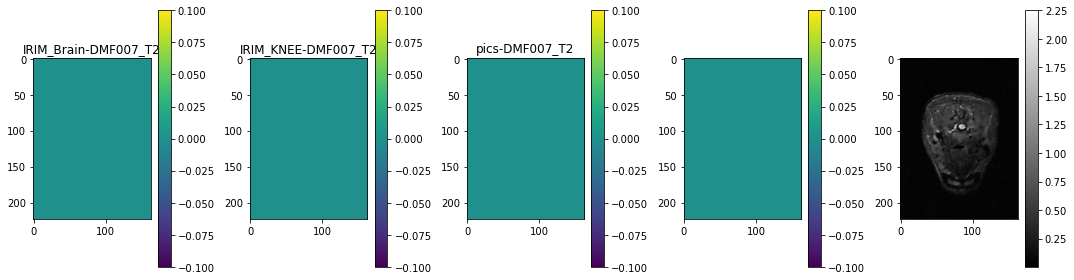

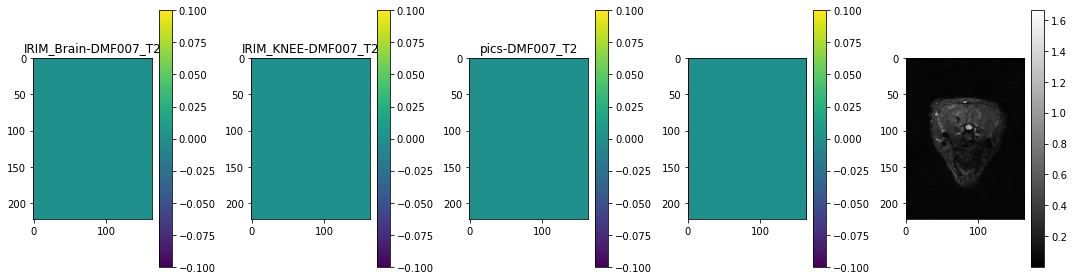

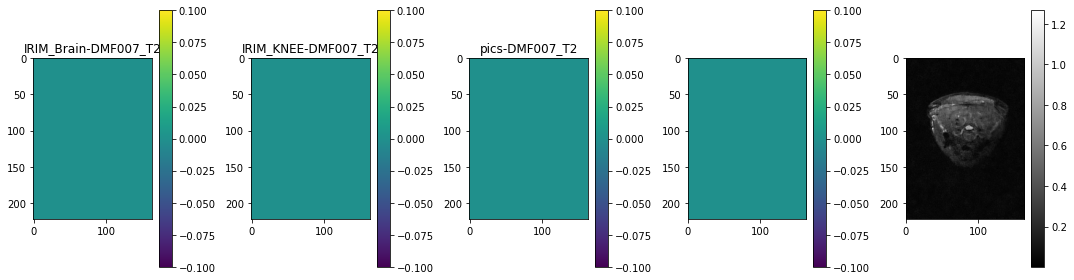

In [77]:
segmentation_dict = voting_segmentation()

subjects_id = os.listdir("/data/projects/tecfidera/data/h5_new/nonorm/")
subjects_id = [i[:6] for i in subjects_id]

loop_list = sorted(os.listdir(lesions))
master_list = []
for i in subjects_id:
    tmp_file_list = []
    for j in loop_list:
        if i in j:
            tmp_file_list.append(j)
    master_list.append(tmp_file_list)
# print(master_list)

for file_list in master_list:
    for j in range(0, 220, 10):
        fig = plt.figure(figsize=(15, 4))
        for cntr, i in enumerate(file_list):
            path = os.path.join(lesions, i, "FLAIR_lesion.nii.gz")
            segmentation = load_seg(path)

            plt.subplot(1, 5, cntr+1)
            ax = plt.imshow(segmentation[j, :, :])
            plt.colorbar(ax)
            plt.title(i)

        plt.subplot(1, 5, 4)
        ax = plt.imshow(segmentation_dict["DMF007_T2_AXFLAIR.h5"][j, : :])
        plt.colorbar(ax)

        plt.subplot(1, 5, 5)
        ax = plt.imshow(np.abs(reconstrution[j, 0, : :]), cmap="gray")
        plt.colorbar(ax)

        plt.tight_layout()
        plt.show()
    break

In [78]:
recon_dataset_path = "/data/projects/tecfidera/data/h5_recon_dataset/"
recon_dataset_files = os.listdir(recon_dataset_path)

In [79]:
for i in recon_dataset_files:
    coronal_dict = {}
    sagittal_dict = {}
    hf = h5py.File(os.path.join(recon_dataset_path, i))

    output_coronal = os.path.join(recon_dataset_path, i[:-14] + "_coronal.h5")
    output_sagittal = os.path.join(recon_dataset_path, i[:-14] + "_sagittal.h5")

    image_space = np.fft.ifftn(hf["kspace"], axes=(2, 3))
    coronal_dict["kspace"] = np.fft.fftn(np.transpose(image_space, axes=(2, 1, 0, 3)), axes=(2, 3)).astype(np.complex64)
    sagittal_dict["kspace"] = np.fft.fftn(np.flip(np.transpose(image_space, axes=(3, 1, 0, 2)), axis=(-1)), axes=(2, 3)).astype(np.complex64)

    coronal_dict["lesion_segmentation"] = np.transpose(hf["lesion_segmentation"], axes=(1, 0, 2)).astype(np.uint8)
    sagittal_dict["lesion_segmentation"] = np.flip(np.transpose(hf["lesion_segmentation"], axes=(2, 0, 1)), axis=(-1)).astype(np.uint8)

    coronal_dict["sensitivity_map"] = np.transpose(hf["sensitivity_map"], axes=(2, 1, 0, 3)).astype(np.complex64)
    sagittal_dict["sensitivity_map"] = np.flip(np.transpose(hf["sensitivity_map"], axes=(3, 1, 0, 2)), axis=(-1)).astype(np.complex64)

    coronal_dict["reconstruction_sense"] = np.transpose(hf["reconstruction_sense"], axes=(2, 1, 0, 3)).astype(np.complex64)
    sagittal_dict["reconstruction_sense"] = np.flip(np.transpose(hf["reconstruction_sense"], axes=(3, 1, 0, 2)), axis=(-1)).astype(np.complex64)

    with h5py.File(output_coronal, "w") as bf:
        for key, data in coronal_dict.items():
            bf.create_dataset(key, data=data, compression='gzip')
        bf.attrs['reconstruction_model'] = hf.attrs['reconstruction_model']

    with h5py.File(output_sagittal, "w") as ff:
        for key, data in sagittal_dict.items():
            ff.create_dataset(key, data=data, compression='gzip')
        ff.attrs['reconstruction_model'] = hf.attrs['reconstruction_model']


In [5]:
data_path = "/data/projects/tecfidera/data/h5_recon_dataset/"
tecfider_files = os.listdir(data_path)

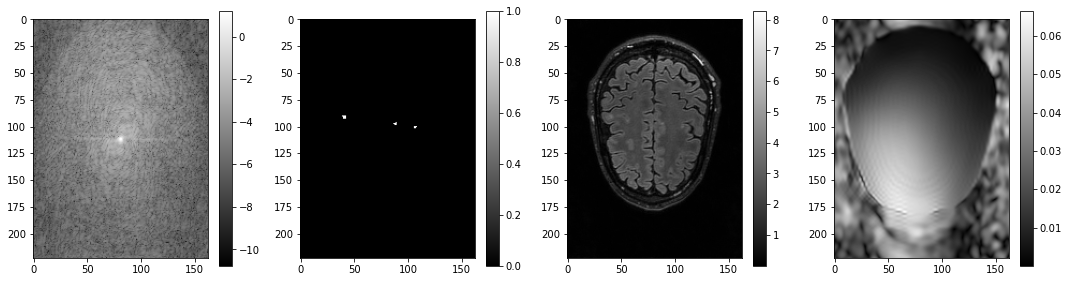

In [12]:
segmentationview_mri(data_path, index=40, coil=0, file_index=2)